In [1]:
import numpy as np
import dask
import shapely

from spatialdata import to_polygons, SpatialData
from spatialdata.transformations.transformations import Identity
import geopandas as gpd

import tifffile
import spatial_image
import spatialdata_plot
import matplotlib.pyplot as plt

import cv2
from skimage.measure import find_contours
from skimage.morphology import remove_small_holes
from scipy.ndimage import find_objects

### Examples of the masks

In [2]:
masks_macrophages = tifffile.imread("./macrophages.tiff")
mask_microglia = tifffile.imread("./microglia.tif")

### SpatialData example

In [3]:
simage_macrophages = spatial_image.to_spatial_image(
	dask.array.from_array(masks_macrophages)
)
simage_microglia = spatial_image.to_spatial_image(
	dask.array.from_array(mask_microglia)
)


simage_macrophages = simage_macrophages.assign_attrs(
    {
        "transform": {"global": Identity()}
    }
)
simage_microglia = simage_microglia.assign_attrs(
    {
        "transform": {"global": Identity()}
    }
)

sdata_macrophages = SpatialData(labels={
	"labels": simage_macrophages
})
sdata_microglia = SpatialData(labels={
	"labels": simage_microglia
})

In [4]:
sdata_macrophages["vectorized"] = to_polygons(simage_macrophages)
# 20s811ms

In [5]:
sdata_microglia["vectorized"] = to_polygons(simage_microglia)
# 13ms

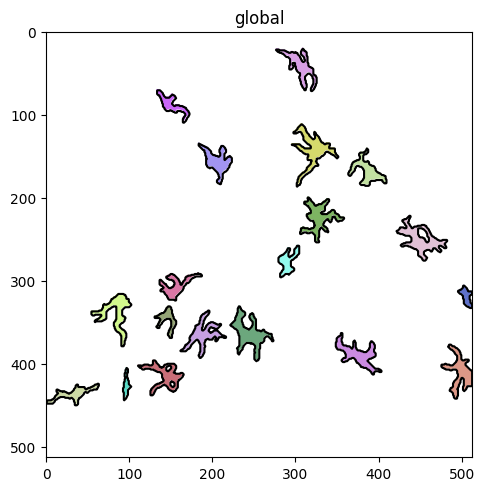

In [6]:
sdata_microglia.pl.render_labels().pl.render_shapes(
	"vectorized", outline=True, fill_alpha=0
).pl.show()
# Masks are plotted correctly

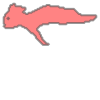

In [7]:
sdata_macrophages["vectorized"].iloc[0]["geometry"]
# Invalid geometry and single pixel hole in the mask 

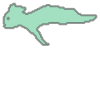

In [8]:
shapely.make_valid(sdata_macrophages["vectorized"].iloc[0]["geometry"])

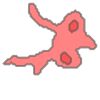

In [9]:
sdata_microglia["vectorized"].iloc[16]["geometry"]

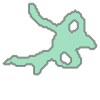

In [10]:
shapely.make_valid(sdata_microglia["vectorized"].iloc[16]["geometry"])

### Difference between cv2 and skimage find_contours

In [11]:
microglia_objects = find_objects(mask_microglia)

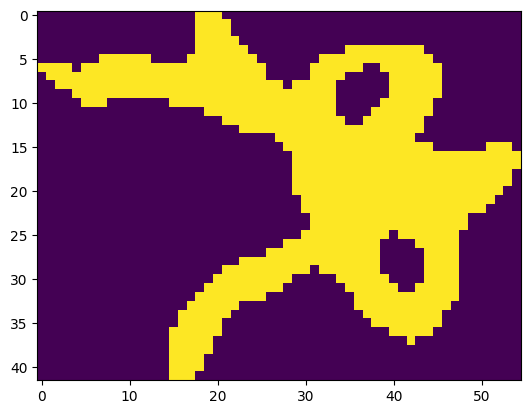

In [12]:
for i, sl in enumerate(microglia_objects):
	if i == 16:
		image = mask_microglia[sl] == i + 1

plt.imshow(image)

In [13]:
skimage_contours = find_contours(image)

In [14]:
len(skimage_contours)

6

In [15]:
cv2_contours, hierarchy = cv2.findContours(
	image=image.astype(np.uint8),
	mode=cv2.RETR_TREE,
	method=cv2.CHAIN_APPROX_NONE
)
# ~Same execution time though there are different algorithms

In [16]:
len(cv2_contours)

3

### Custom implementation

In [17]:
def filter_multipolygons(
    multipolygon: shapely.MultiPolygon, geom_area_threshold: int = 20
):
    if not isinstance(multipolygon, shapely.MultiPolygon):
        return multipolygon
    filtered_geoms = [
        geom for geom in multipolygon.geoms if geom.area >= geom_area_threshold
    ]
    if len(filtered_geoms) == 1:
        return shapely.Polygon(filtered_geoms[0])
        # Probably redundant conversion
    elif len(filtered_geoms) == 0:
        return shapely.Polygon()
        # Sometimes the case but can be later removed grom gpd.GeoDataFrame
    else:
        return shapely.MultiPolygon(filtered_geoms)


def check_polygon_validity(polygon: shapely.Polygon, area_threshold: int = 5):
    if not polygon.is_valid:
        geometry_collection = shapely.make_valid(polygon)
        valid_geoms = []
        for geom in geometry_collection.geoms:
            if isinstance(geom, shapely.MultiPolygon):
                valid_geoms.append(filter_multipolygons(geom, area_threshold))
            elif isinstance(geom, shapely.Polygon):
                if geom.area >= area_threshold:
                    valid_geoms.append(geom)
            else:  # Dropping all the line strings and other shapes
                continue
        if len(valid_geoms) > 1:
            # TODO: Better to make multipolygon
            return shapely.GeometryCollection(valid_geoms)
        else:
            return valid_geoms[0]
    return polygon


def get_polygon(outline: np.ndarray, keep_holes: bool = False) -> list | None:
    cv2_method = cv2.RETR_TREE if keep_holes else cv2.RETR_EXTERNAL
    contours, hierarchy = cv2.findContours(
        image=outline,
        mode=cv2_method,
        method=cv2.CHAIN_APPROX_NONE,
    )
    outline = contours[0].squeeze()  # Not always the case
    if outline is None:
        return outline  # TODO: Is there actually such cases?
    if keep_holes and hierarchy.shape[1] > 1:
        inner_outlines = []
        for c_idx in range(1, len(hierarchy[0, 1:]) + 1):  # Skipping main contour
            inner_outline = contours[c_idx].squeeze()
            if len(inner_outline) < 4:
                continue  # Case when weird outline
            inner_outlines.append(inner_outline)
        try:
            return shapely.Polygon(shell=outline, holes=inner_outlines)
        except ValueError:
            return shapely.Polygon(shell=inner_outlines[0])
        # A bit messy because the hierarchy sometimes funky
    else:
        return shapely.Polygon(outline)


def outlines_polygons(
    masks: np.ndarray,
    keep_holes: bool = False,
    min_hole_area: int = 3,
) -> list:
    polygons: list = []
    objects = find_objects(masks)
    for i, sl in enumerate(objects):
        if sl is None:
            continue
        lb = i + 1
        image = masks[sl] == lb
        image = remove_small_holes(image, area_threshold=min_hole_area)
        outline = image.astype(np.uint8)
        polygon = get_polygon(outline, keep_holes)
        polygon = check_polygon_validity(polygon)
        polygons.append(polygon)
    # Can be already converted to gpd.GeoDataFrame
    return polygons

In [18]:
df_microglia = gpd.GeoDataFrame(outlines_polygons(mask_microglia, keep_holes=True), columns=["geometry"]).set_geometry("geometry")
# 9ms

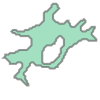

In [19]:
df_microglia.iloc[6]["geometry"]

In [20]:
df = gpd.GeoDataFrame(outlines_polygons(masks_macrophages, keep_holes=True), columns=["geometry"]).set_geometry("geometry")
# 9s901ms

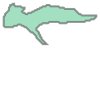

In [21]:
check_polygon_validity(df.iloc[0]["geometry"], area_threshold=5)

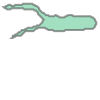

In [22]:
df.iloc[174]["geometry"].geoms[1]

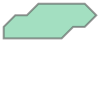

In [24]:
df.iloc[174]["geometry"].geoms[0]

In [25]:
df.iloc[174]["geometry"].geoms[0].area  # Above threshold

17.5